In [7]:
%reload_ext autoreload
%autoreload 2
from fun import *
import polars as pl
import pandas as pd
import datetime as dt
import time 


logging = get_logger(log_file='回测.log',inherit=False)

start_date = dt.date(2021,1,1)
end_date = dt.datetime.today()

# 获取指定日期的日线数据
stock_data = read_day_data(start_date=start_date,end_date=end_date,file_path='ts_stock_all_data')
stock_data = stock_data.drop_nulls(subset=['open','close','pre_close','limit_up','limit_down'])
market_value = read_day_data(start_date=start_date,end_date=end_date,file_path='ts_daily_basic')
market_value = market_value.with_columns([
   ( pl.col('free_share')*pl.col('close')/1e4).alias('free_float_mv')
])
stock_data = stock_data.join(market_value.select(['code','trading_date','free_float_mv']),on=['code','trading_date'],how='left')
#stock_data.schema
# 去掉没用的列
stock_data = stock_data.drop(['change','total_share','attack','activity','pe','float_share','buying','selling','swing','strength','avg_turnover'])

In [8]:
# 1.涨停标记
# 标记涨停状态：limit_status
stock_data = mark_limit_status(stock_data)
# 标记涨停描述：limit_desc
stock_data = mark_limit_desc(stock_data)
# 记录最近的一次涨停描述：last_limit_desc
stock_data = mark_last_limit_desc(stock_data)
# 统计10天内涨停平均换手率
stock_data = cal_limit_avg_turnover(stock_data, window=5)

# 2.均线特征
# 计算均线:sma_{window}
stock_data = add_sma(stock_data, window=5)
stock_data = add_sma(stock_data, window=7)
"""
#stock_data = add_ema(stock_data, window=4)
#stock_data = add_ema(stock_data, window=7)
#stock_data = add_ewma_volatility(stock_data, window=8)
"""
# 3.计算开盘涨幅:open_chg,乖离率,成交均价vwap
stock_data = stock_data.with_columns(
    (
        (pl.col("open") - pl.col("pre_close")) 
        / pl.col("pre_close") 
        * 100
    ).alias("open_pct"),  # 开盘涨幅百分比
    ((pl.col("close") - pl.col("sma_7")) / pl.col("sma_7") * 100).alias("close_sma7_pct"), #乖离率
    (pl.col("amount")*100 / pl.col("volume")).alias("vwap"),
    ((pl.col("low") <= pl.col("limit_down")*1.01)).alias("touch_limit_down"), # 是否触及跌停
)
stock_data = cal_n_lowest(stock_data)


# 3.k线特征
# 计算量比,k线特征
#stock_data = add_volume_ratio(stock_data, window=5)
#stock_data = cal_kline_pattern_features(stock_data)


# 筛选stock_data行 为买入信号 1. 昨日涨停or断板or炸板   2.今日低开-3%至-4%  3.昨日收盘在昨日日五线上   4. 最近一次涨停描述 !=一天一板 或者 非空
# 1. 先确保数据按股票和日期排序
stock_data = stock_data.sort(["code", "trading_date"])

# 2. 在每个股票组内计算移位数据（关键步骤）
stock_data = stock_data.with_columns([
    # 同一股票内的前一天涨停状态
    pl.col("limit_status").shift(1).over("code").alias("prev_limit_status"),
    # 同一股票内的前一天5日均线
    pl.col("sma_7").shift(1).over("code").alias("prev_sma_7"),
    #pl.col("ema_7").shift(1).over("code").alias("prev_ema_7"),
    #pl.col("volume_ratio_5").shift(1).over("code").alias("pre_volume_ratio_5"),
    pl.col("pct").shift(1).over("code").alias("pre_pct"),
    pl.col("vwap").shift(1).over("code").alias("pre_vwap"),
    #pl.col("ewma_volatility_8").shift(1).over("code").alias("pre_ewma_volatility_8"),
    pl.col("close_sma7_pct").shift(1).over("code").alias("pre_close_sma7_pct"),
    
    # k线特征
    # pl.col("body_ratio").shift(1).over("code").alias("pre_body_ratio"),
    # pl.col("upper_shadow_ratio").shift(1).over("code").alias("pre_upper_shadow_ratio"),
    # pl.col("lower_shadow_ratio").shift(1).over("code").alias("pre_lower_shadow_ratio"),
    # pl.col("candle_direction").shift(1).over("code").alias("pre_candle_direction")
])

# 3. 基于组内移位后的数据筛选买入信号
# 条件参数字典
params_dict={
    'low':-5,
    'high':-2.5,
    'mv_min':35,
    'mv_max':1000,
    'prev_limit_status':['断板','炸板'],
    'avg_limit_turnover_5_min':-1
}
# polars的信号文件
信号文件= stock_data.filter(
    # 非st,创业,科创
    ~(pl.col("type").is_not_null() & (pl.col("type") == "ST")) &
    ~(pl.col("code").str.split(".").list[1].str.starts_with("30") | pl.col("code").str.split(".").list[1].str.starts_with("688")) &

    # 1. 昨日or断板or炸板（使用组内移位后的数据）
    (pl.col("prev_limit_status").is_in(params_dict['prev_limit_status'])) &
    
    # 2. 今日低开-3%至-4%
    (pl.col("open_pct") >= params_dict["low"]) & (pl.col("open_pct") <= params_dict["high"]) &
    
    # 3. 昨日收盘在昨日5日均线上
    (pl.col("pre_close") >= pl.col("prev_sma_7")) &
    
    # 4. 最近一次涨停描述 != 一天一板 或者 空缺
    (
        (pl.col("last_limit_desc") != "1天1板") &
        #(pl.col("last_limit_desc") == "2天1板") 
        (pl.col("last_limit_desc").is_not_null())
    ) &

    # 5. 自由流通值大于
    ((pl.col("free_float_mv") >= params_dict["mv_min"]) & (pl.col("free_float_mv") <= params_dict["mv_max"])) 

    # 6. 绝对位置不能太高，不能触发严重异动
    & ((pl.col("open")/pl.col("lowest_30")) <=3 )
    
    # 均线偏离度大于11或小于9
    #& ((pl.col("pre_close_sma7_pct") <= 9))
)
# 筛选数据并添加signal列
stock_data = stock_data.with_columns(
    # 构建筛选条件表达式
    signal = pl.when(
        # 非st,创业,科创
        ~(pl.col("type").is_not_null() & (pl.col("type") == "ST")) &
        ~(pl.col("code").str.split(".").list[1].str.starts_with("30") | 
          pl.col("code").str.split(".").list[1].str.starts_with("688")) &

        # 1. 昨日or断板or炸板（使用组内移位后的数据）
        (pl.col("prev_limit_status").is_in(params_dict['prev_limit_status'])) &

        # 2. 今日低开-3%至-4%
        (pl.col("open_pct") >= params_dict["low"]) & 
        (pl.col("open_pct") <= params_dict["high"]) &

        # 3. 昨日收盘在昨日5日均线上（注意你代码里写的是prev_sma_7，确认是否是笔误）
        (pl.col("pre_close") >= pl.col("prev_sma_7")) &

        # 4. 最近一次涨停描述 != 一天一板 且 非空
        (pl.col("last_limit_desc") != "1天1板") &
        (pl.col("last_limit_desc").is_not_null()) &

        # 5. 自由流通值区间
        (pl.col("free_float_mv") >= params_dict["mv_min"]) & 
        (pl.col("free_float_mv") <= params_dict["mv_max"]) &

        # 6. 最近的涨停平均换手率
        #(pl.col("avg_limit_turnover_5") >= params_dict["avg_limit_turnover_5_min"]) &

        # 6. 绝对位置不能太高，不能触发严重异动
        ((pl.col("open")/pl.col("lowest_30")) <= 3)
        
    ).then(1).otherwise(0)
)

# 如果需要只筛选出signal=1的行（可选）
信号文件 = stock_data.filter(pl.col("signal") == 1)

logging.info(f"回测信号参数: {params_dict}")

回测信号参数: {'low': -5, 'high': -2.5, 'mv_min': 35, 'mv_max': 1000, 'prev_limit_status': ['断板', '炸板'], 'avg_limit_turnover_5_min': -1}


In [9]:
from trade_fun import *
start_date_str = start_date.strftime("%Y-%m-%d")
end_date_str = end_date.strftime("%Y-%m-%d")
#end_date_str = '2025-11-17'

logging.info(f"回测时间区间: {start_date_str} 至 {end_date_str}")
result_df,merged_df = cal_trade_info(信号文件,trade_fun=trade,start_date=start_date_str,end_date=end_date_str)


回测时间区间: 2021-01-01 至 2026-01-09
使用40个进程并行处理，共831个日期任务
回测任务进度: 100%|███████████████████████| 831/831 [02:52<00:00,  4.80个日期/s]
所有回测任务完成，共处理831个日期的结果


1.33.1


e:\working\anaconda3\envs\quant\lib\functools.py:888: DataOrientationWarning:

Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.

总调整天数: 77, 调整正确率: 57.29%, 预计平均亏损改善: 2.6401%
回测结果(不风控):

回测时间:2021-01-04 - 2026-01-09
策略胜率: 44.77%
策略盈亏比: 1.43
每日平均开仓个数: 2.40
平均持仓天数: 1.59 天
每单位风险期望收益:0.0888
策略总收益率: 322.12%
策略年化收益率: 33.25%
最大回撤: -57.10%
最大回撤阶段: 2022-07-21 至 2024-04-15
夏普比率: 0.88
策略超额年化收益率: 29.96%
最终净值: 4.2212


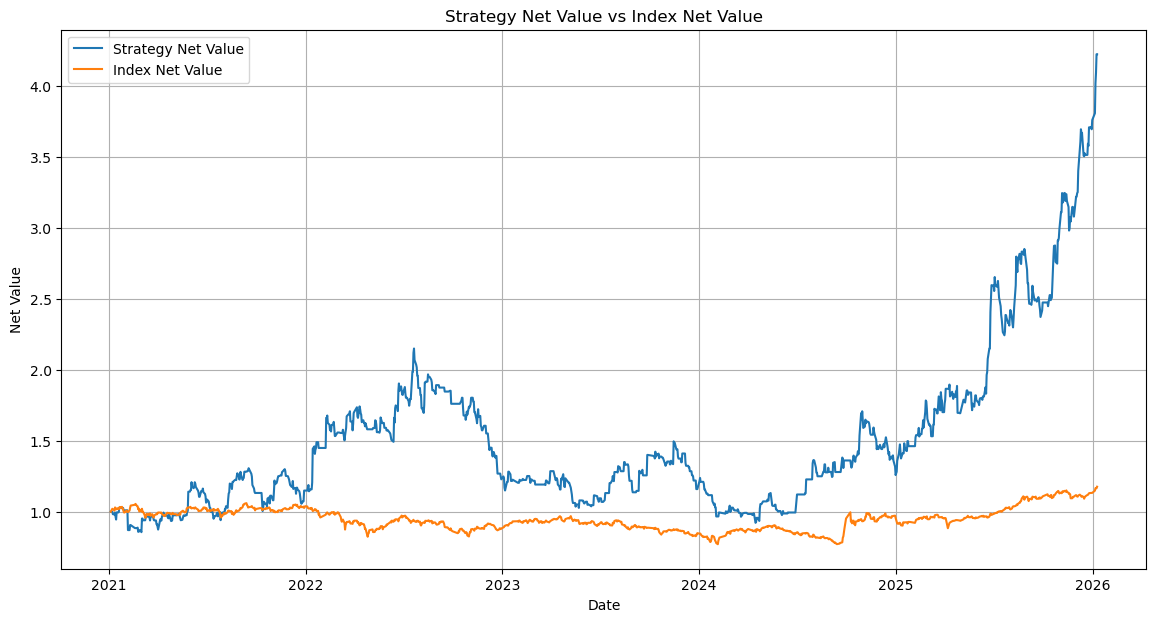

回测结果(触及跌停风控):

回测时间:2021-01-04 - 2026-01-09
策略胜率: 45.00%
策略盈亏比: 1.48
每日平均开仓个数: 2.40
平均持仓天数: 1.59 天
每单位风险期望收益:0.1149
策略总收益率: 362.62%
策略年化收益率: 35.71%
最大回撤: -54.61%
最大回撤阶段: 2022-07-21 至 2024-04-15
夏普比率: 0.94
策略超额年化收益率: 32.42%
最终净值: 4.6262


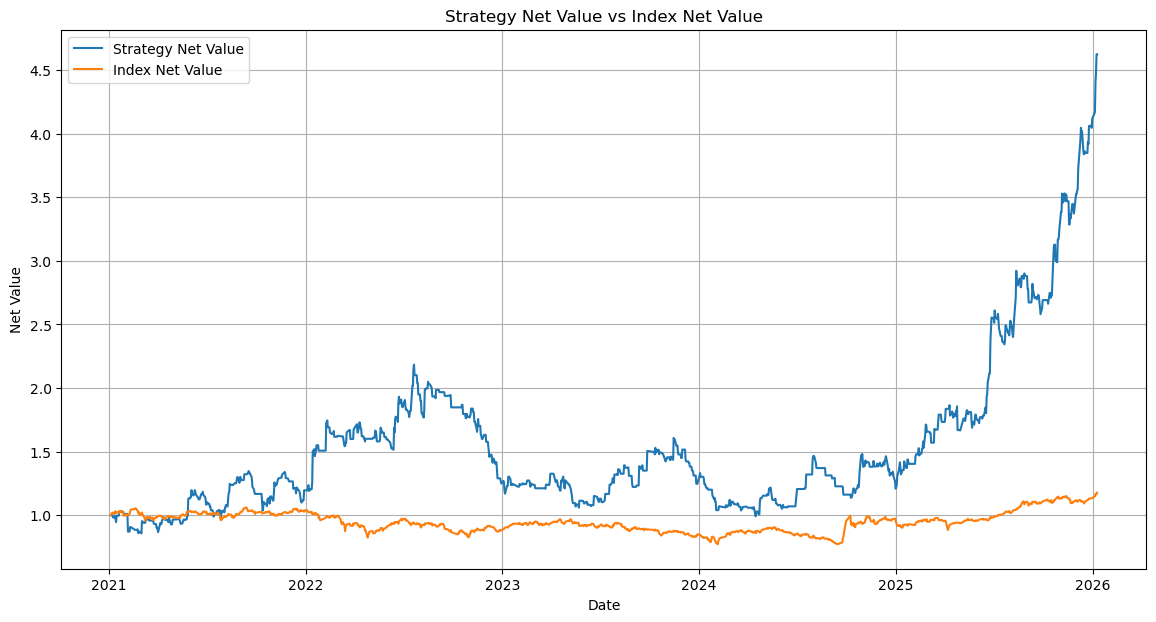

回测结果(买点下移风控):

回测时间:2021-01-04 - 2026-01-09
策略胜率: 44.18%
策略盈亏比: 1.46
每日平均开仓个数: 2.40
平均持仓天数: 1.59 天
每单位风险期望收益:0.0874
策略总收益率: 275.71%
策略年化收益率: 30.20%
最大回撤: -55.24%
最大回撤阶段: 2022-07-21 至 2024-04-15
夏普比率: 0.83
策略超额年化收益率: 26.91%
最终净值: 3.7571


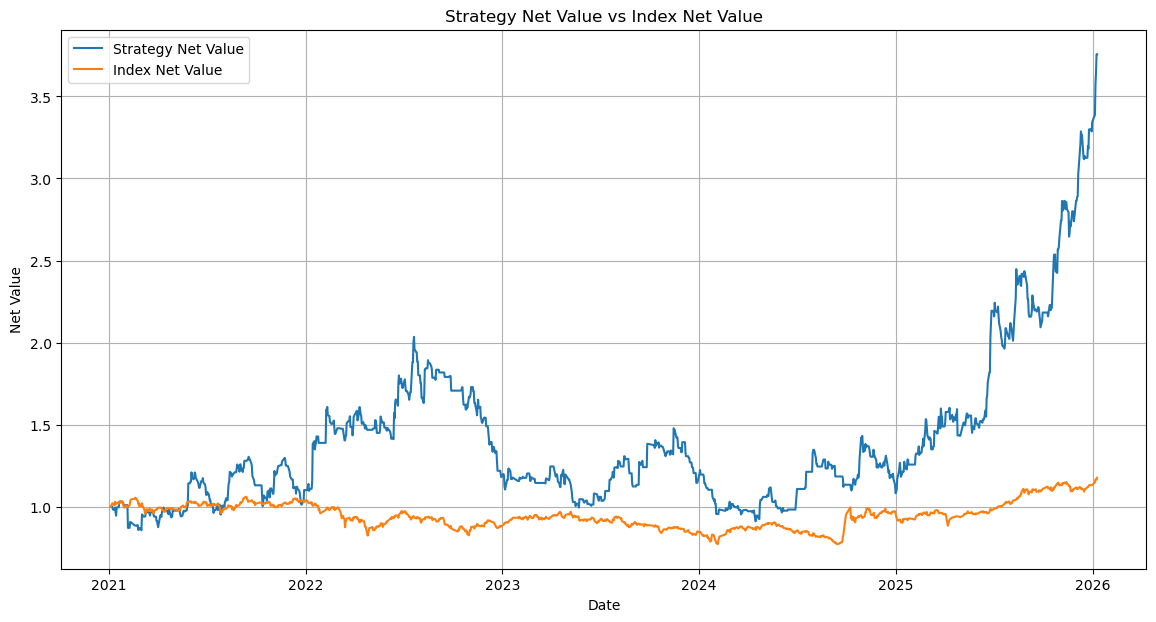

In [12]:
from trade_fun import report_backtest_full
from fun import *
from trade_fun import adjust_weight_by_near_n # 触及跌停调仓

# 取sell_date为前n个窗口的股票表现与平均水平进行对比。高于平均水平并且昨日的股票触及跌停达到一定比率，则仓位调整为min_weight

print(pl.__version__)
#print(type(merged_df))
# 构建文件名
filename = f"信号文件/断板低开{params_dict['low']}-{params_dict['high']} {dt.datetime.now().strftime('%Y%m%d_%H%M%S')}(sma7).csv"
# 使用Python的文件操作指定编码
#merged_df.write_csv(filename, include_bom=True)

result_df1 = pd.read_csv('信号文件/断板低开-5--2.5 20251024_100549(sma7).csv',encoding='utf-8-sig') 
result_df2 = pd.read_csv('信号文件/涨停低开-5--2.5 20251016_061011(ma7).csv',encoding='utf-8-sig')
result_df3 = pd.read_csv('信号文件/断板低开-5--2.5 20251121_214049(sma7).csv',encoding='utf-8-sig') # 10日线

# 仓位控制风控(merged_df_with_weight)
merged_df_with_weight = adjust_weight_by_near_n(merged_df) 
"""触及跌停风控"""
merged_df_with_weight = merged_df_with_weight.with_columns(
    (pl.col("profit") * pl.col("weight")).alias("weight_profit")
)
#merged_df_with_weight.write_csv(filename, include_bom=True)
# 买点下移风控(merged_df_with_weight_adjust)
rate_move = 0.02
# 增加买点下移的逻辑（当weight=0时,如果low<=open*(1-rate_move)时,买点下移rate_move（也就是profit+rate_move*100），否则profit=0）
merged_df_with_weight_adjust = merged_df_with_weight.with_columns(
    pl.when(pl.col("weight") != 0)
    # 条件1：weight≠0 → 保持原profit不变
    .then(pl.col("profit"))
    # 条件2：weight==0 → 进一步判断low是否满足下移条件
    .otherwise(
        pl.when(pl.col("low") <= pl.col("open") * (1 - rate_move))
        # 子条件1：满足下移 → profit+rate_move*100
        .then(pl.col("profit") + rate_move * 100)
        # 子条件2：不满足下移 → profit=0
        .otherwise(0)
    ).alias("profit")  # 覆盖原profit列
) #买点下移回测
"""买点下移风控"""
merged_df_with_weight_adjust = merged_df_with_weight_adjust.with_columns(
    (pl.col("profit") *0.4).alias("weight_profit")
)

merged_df = merged_df.with_columns((pl.col("profit") *0.4).alias("weight_profit"))
result_df['weight_profit'] = result_df['profit'] *0.4
result_df1['weight_profit'] = result_df1['profit'] *0.4
result_df2['weight_profit'] = result_df2['profit'] *0.4
result_df3['weight_profit'] = result_df3['profit'] *0.4

# 回测结果汇报
#back_result =report_backtest_full(result_df, start_date = '2025-01-01', end_date='2025-12-20',profit_col='weight_profit')
#back_result =report_backtest_full(result_df, start_date = '2025-01-01', end_date='2025-12-20',profit_col='weight_profit')
logging.info("回测结果(不风控):")
back_result =report_backtest_full(merged_df.to_pandas(), start_date = '2021-01-01', end_date=end_date_str,profit_col='weight_profit')
logging.info("回测结果(触及跌停风控):")
back_result =report_backtest_full(merged_df_with_weight.to_pandas(), start_date = '2021-01-01', end_date=end_date_str,profit_col='weight_profit')
logging.info("回测结果(买点下移风控):")
back_result =report_backtest_full(merged_df_with_weight_adjust.to_pandas(), start_date = '2021-01-01', end_date=end_date_str,profit_col='weight_profit')

# 将回测结果保存到日志中
#logging.info("\n" + back_result.to_string(index=False))


回测时间:2021-01-04 - 2021-12-31
策略胜率: 43.84%
策略盈亏比: 1.38
每日平均开仓个数: 2.18
平均持仓天数: 1.59 天
每单位风险期望收益:0.0423
策略总收益率: 19.54%
策略年化收益率: 19.78%
最大回撤: -23.08%
最大回撤阶段: 2021-09-17 至 2021-10-13
夏普比率: 0.61
策略超额年化收益率: 15.83%
最终净值: 1.1954


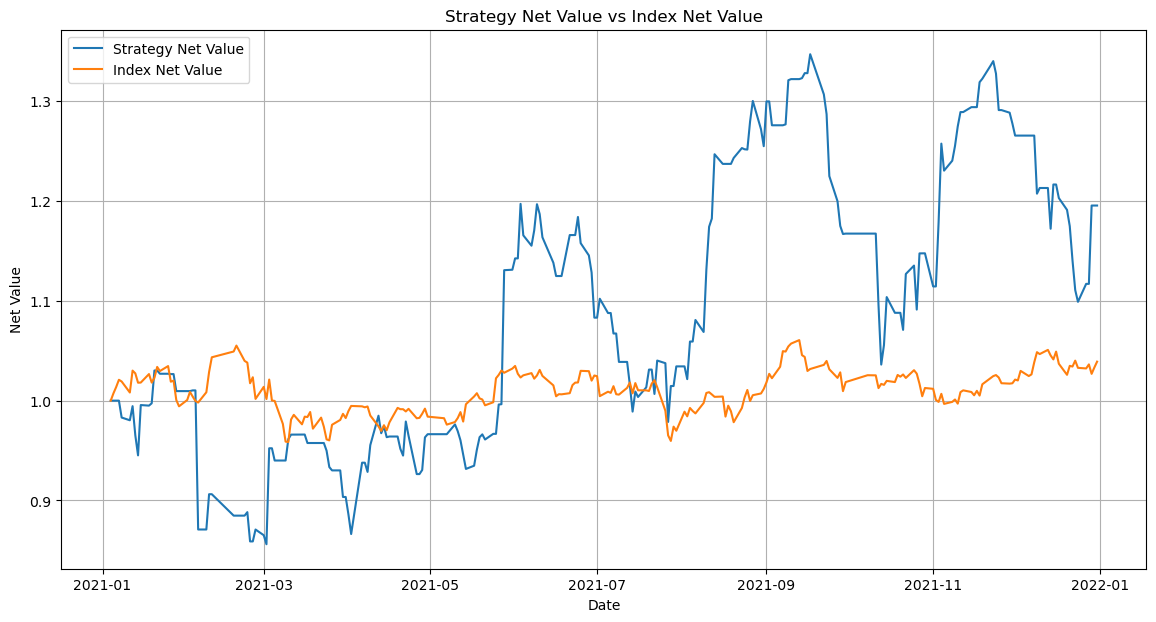

In [13]:
back_result =report_backtest_full(merged_df_with_weight.to_pandas(), start_date = '2021-01-01', end_date='2022-01-01',profit_col='weight_profit')

In [11]:
import pandas as pd
import numpy as np
import plotly.express as px


def factor_group_profit_plot(
    df: pd.DataFrame,
    factor_col: str,
    profit_col: str,
    bins: int = 5,
    bin_method: str = 'qcut',
    plot: bool = True,
    report_func=report_backtest_full,  # 新增参数，回测汇报函数
    report_kwargs={
        'start_date': '2025-01-01',
        'end_date': end_date,
        'profit_col': 'profit'
    } # 新增参数，回测函数的额外参数
) -> pd.DataFrame:
    """
    按因子分组统计收益率，并可对每组调用回测汇报函数，结果合并到desc_stats
    params:
        df: 包含因子值和收益率的DataFrame
        factor_col: 因子列名
        profit_col: 收益率列名
        bins: 分组数或分组边界列表
        bin_method: 分组方法，'qcut'或'cut'。qcut表示等分位数分组，cut表示等宽分组
        plot: 是否绘制小提琴图
        report_func: 回测汇报函数，接受DataFrame和额外参数，返回指标DataFrame
        report_kwargs: 传递给回测函数的额外参数字典
    """
    import pandas as pd
    import numpy as np
    import plotly.express as px

    df = df.copy()
    factor_dtype = df[factor_col].dtype
    start_date = report_kwargs.get('start_date', '2025-01-01')
    end_date = report_kwargs.get('end_date')
    df = df[
        (pd.to_datetime(df['trading_date']) >= pd.to_datetime(start_date)) &
        (pd.to_datetime(df['trading_date']) <= pd.to_datetime(end_date))
    ]

    if np.issubdtype(factor_dtype, np.number):
        if bin_method == 'qcut':
            df['_factor_bin'] = pd.qcut(df[factor_col], q=bins, duplicates='drop')
        else:
            df['_factor_bin'] = pd.cut(df[factor_col], bins=bins)
        group_col = '_factor_bin'
        df['_factor_bin'] = df['_factor_bin'].astype(str)
        def get_bin_midpoint(bin_value):
            if isinstance(bin_value, pd.Interval):
                return (bin_value.left + bin_value.right) / 2
            else:
                try:
                    bin_str = str(bin_value).strip('[]() ')
                    left_str, right_str = bin_str.split(',')
                    left = float(left_str.strip())
                    right = float(right_str.strip())
                    return (left + right) / 2
                except Exception:
                    return 0
        unique_bins = df[group_col].dropna().unique()
        bin_order = sorted(unique_bins, key=get_bin_midpoint)
        df[group_col] = pd.Categorical(df[group_col], categories=bin_order, ordered=True)
    else:
        group_col = factor_col
        df[group_col] = pd.Categorical(df[group_col], categories=sorted(df[group_col].unique()), ordered=True)

    desc_stats = df.groupby(group_col, observed=True)[profit_col].describe().reset_index()
    desc_stats = desc_stats.rename(columns={
        'count': '样本数', 'mean': '均值', 'std': '标准差', 'min': '最小值',
        '25%': '25分位', '50%': '中位数', '75%': '75分位', 'max': '最大值'
    })[[group_col, '样本数', '均值', '标准差', '最小值', '25分位', '中位数', '75分位', '最大值']]

    # 新增：对每个分组调用回测汇报函数
    if report_func is not None:
        metrics_dict_list = []
        for group in desc_stats[group_col]:
            group_df = df[df[group_col] == group]
            if len(group_df) == 0:
                metrics_dict_list.append({})
                continue
            try:
                if report_kwargs.get('plot')==True:
                    logging.info(f"正在计算分组{factor_col} {group} 的回测指标")
                metrics = report_func(group_df, **(report_kwargs or {}))
                # 转为字典：{指标名称: 指标值}
                metrics_dict = dict(zip(metrics['指标名称'], metrics['指标值']))
            except Exception as e:
                metrics_dict = {}
            metrics_dict_list.append(metrics_dict)
        # 将所有指标合并到desc_stats
        metrics_df = pd.DataFrame(metrics_dict_list)
        desc_stats = pd.concat([desc_stats, metrics_df], axis=1)

    if plot:
        fig = px.violin(
            df, y=profit_col, x=group_col, box=True, points="all",
            title=f"{factor_col}分组收益率分布",
            labels={group_col: "分组", profit_col: "收益率"}
        )
        fig.show()
        logging.info("分组描述性统计：")
        logging.info(desc_stats)

    return desc_stats


logging = get_logger(log_file='因子分组回测.log', inherit=False)
#merged_df1 = pd.read_csv('断板低开-5--2.5 20251011_100035.csv',encoding='utf-8-sig') 
df = cal_industry_concentration(merged_df_with_weight.to_pandas(), window=3)
# 因子值计算
#df['trading_date'] = pd.to_datetime(df['trading_date'])
df['price/lowest_30'] = df['open']/df['lowest_30']
#df['pre_candle_direction*pre_body_ratio'] = df['pre_candle_direction']*df['pre_body_ratio']
#df['open-volume_concentration_10/volume_concentration_10'] = (df['open'] - df['pre_volume_concentration_10'])/df['pre_volume_concentration_10'] *100
#df = df[(df['trading_date'] >= '2025-04-08')]
# 分组分析
#desc= factor_group_profit_plot(df, 'pre_volume_ratio_5', 'profit', bins=[0,0.7,0.9,1,1.2,1.4,1.5,1.7,2,2.5,3,4,5], bin_method='cut')
# desc= factor_group_profit_plot(df, 'float_mv', 'profit', bins=[25,50,90,120,160,250,1000], bin_method='cut',
#     report_func=report_backtest_full,  # 你的回测函数
#     report_kwargs={
#         'start_date': '2025-01-01',
#         'end_date': '2025-12-31',
#         'profit_col': 'weight_profit',
#         'return_method':'compand',
#         'plot':True  # 避免在每次调用时绘图
#     })
"""
desc= factor_group_profit_plot(df, 'avg_limit_turnover_5', 'profit', bins=5, bin_method='qcut',
    report_func=report_backtest_full,  # 你的回测函数
    report_kwargs={
        'start_date': '2025-01-01',
        'end_date': '2025-12-31',
        'profit_col': 'weight_profit',
        'return_method':'compand',
        'plot':True  # 避免在每次调用时绘图
    })
"""
#desc= factor_group_profit_plot(df, 'pre_candle_direction', 'profit', bins=3, bin_method='qcut')
#desc = factor_group_profit_plot(df, 'price/lowest_30', 'profit', bins=[0,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0,2.5,3], bin_method='cut')
#desc = factor_group_profit_plot(df, 'pre_candle_direction*pre_body_ratio', 'profit', bins=[-1,-0.5,0,0.5,1], bin_method='cut')

#desc = factor_group_profit_plot(df, 'pre_body_ratio', 'profit', bins=5, bin_method='qcut')
#desc = factor_group_profit_plot(df, 'pre_ewma_volatility_8', 'profit', bins=10, bin_method='qcut') #pre_close_sma7_pct
# desc = factor_group_profit_plot(
#     df,
#     factor_col='industry_concentration',
#     profit_col='profit',
#     bins=4,
#     bin_method='qcut',
#     report_func=report_backtest_full,  # 你的回测函数
#     report_kwargs={
#         'start_date': '2021-01-01',
#         'end_date': '2025-12-24',
#         'profit_col': 'weight_profit',
#         'plot': True  # 避免在每次调用时绘图
#     }
# )
# result_cat = factor_group_profit_plot(df, 'prev_limit_status', 'profit', plot=True)

"\ndesc= factor_group_profit_plot(df, 'avg_limit_turnover_5', 'profit', bins=5, bin_method='qcut',\n    report_func=report_backtest_full,  # 你的回测函数\n    report_kwargs={\n        'start_date': '2025-01-01',\n        'end_date': '2025-12-31',\n        'profit_col': 'weight_profit',\n        'return_method':'compand',\n        'plot':True  # 避免在每次调用时绘图\n    })\n"